In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from gstools import SRF, Gaussian,CovModel
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
class GWR_gau(CovModel):
    def correlation(self,r):
        return np.exp(-0.5*(r/self.len_scale)**2)

In [3]:
def plot_1(b,title='',vmin=1,vmax=6):
    size=50
    plt.imshow(b.reshape(size,size),cmap=plt.cm.get_cmap('bwr',21),vmin=vmin,vmax=vmax)
    plt.title(title)
    plt.colorbar()

In [4]:
size=50

In [5]:
b0 = np.ones(size*size)*3

In [6]:
size=50
model = GWR_gau(dim=2, var=2,len_scale=8)
srf = SRF(model,mean=2,seed=777)
b1 = srf.structured([range(size),range(size)]).reshape(-1)
b1 = b1 - b1.mean()

In [7]:
size=50
model = GWR_gau(dim=2, var=2,len_scale=12)
srf = SRF(model,mean=2,seed=111)
b2 = srf.structured([range(size),range(size)]).reshape(-1)
b2 = b2 - b2.mean()

In [8]:
size=50
def plot_s(bs,vmin=None,vmax=None, title = ""):
    k = len(bs)
    fig, axs = plt.subplots(1, k,figsize=(6*k,4),dpi=600)
    for i in range(2):
        ax = axs[i].imshow(bs[i].reshape(size,size),cmap=plt.cm.get_cmap('viridis',36),
                               vmin=vmin,vmax=vmax,interpolation=None)
        
        fig.colorbar(ax, ax=axs[i])

        axs[i].set_xticks(np.arange(-0.5, size, 5))
        axs[i].set_yticks(np.arange(-0.5, size, 5))
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        axs[i].tick_params(axis='x', colors=(0,0,0,0))
        axs[i].tick_params(axis='y', colors=(0,0,0,0))
        if i ==0:
            axs[i].set_title(r"$\beta_1$",fontsize=18, y=1.02)
        if i ==1:
            axs[i].set_title(r"$\beta_2$",fontsize=18, y=1.02)
    
    for i in range(k):
        if i == 2:
            axs[i].scatter(X1,bs[i],s=5)            
            axs[i].set_title(r"$X_1^2$",fontsize=18, y=1.02)
            
            axs[i].set_xlim(-2.5,2.5)
            axs[i].set_ylim(-1,5)
        if i == 3:
            axs[i].scatter(X2,bs[i],s=5)
            #axs[i].set_xlabel(r"$X_2$",fontsize=16)
            axs[i].set_title(r"$2X_2$",fontsize=18, y=1.02)
            
            axs[i].set_xlim(-2.5,2.5)
            axs[i].set_ylim(-5,5)
            
    fig.suptitle(title, fontsize=20,y=1.1)

In [9]:
np.random.seed(111)

X1 = np.random.uniform(-2,2,size*size)
X2 = np.random.uniform(-2,2,size*size)

X = np.vstack([X1,X2]).T

u = np.array([np.linspace(0,size-1,num=size)]*size).reshape(-1)
v = np.array([np.linspace(0,size-1,num=size)]*size).T.reshape(-1)
coords = np.array(list(zip(u,v)))

In [10]:
np.random.seed(111)

f0 = b0
f1 = b1*X1 + X1**2
f2 = b2*X2 + X2*2

err = np.random.randn(size*size)*0.5

y = (f0 + f1 + f2 + err).reshape(-1)

In [11]:
X_coords = pd.DataFrame(X, columns=['X1','X2'])

In [12]:
1 - np.sum((err)**2)/np.sum((y-y.mean())**2)

0.9782269752342803

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_60593/3399789682.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax = axs[i].imshow(bs[i].reshape(size,size),cmap=plt.cm.get_cmap('viridis',36),


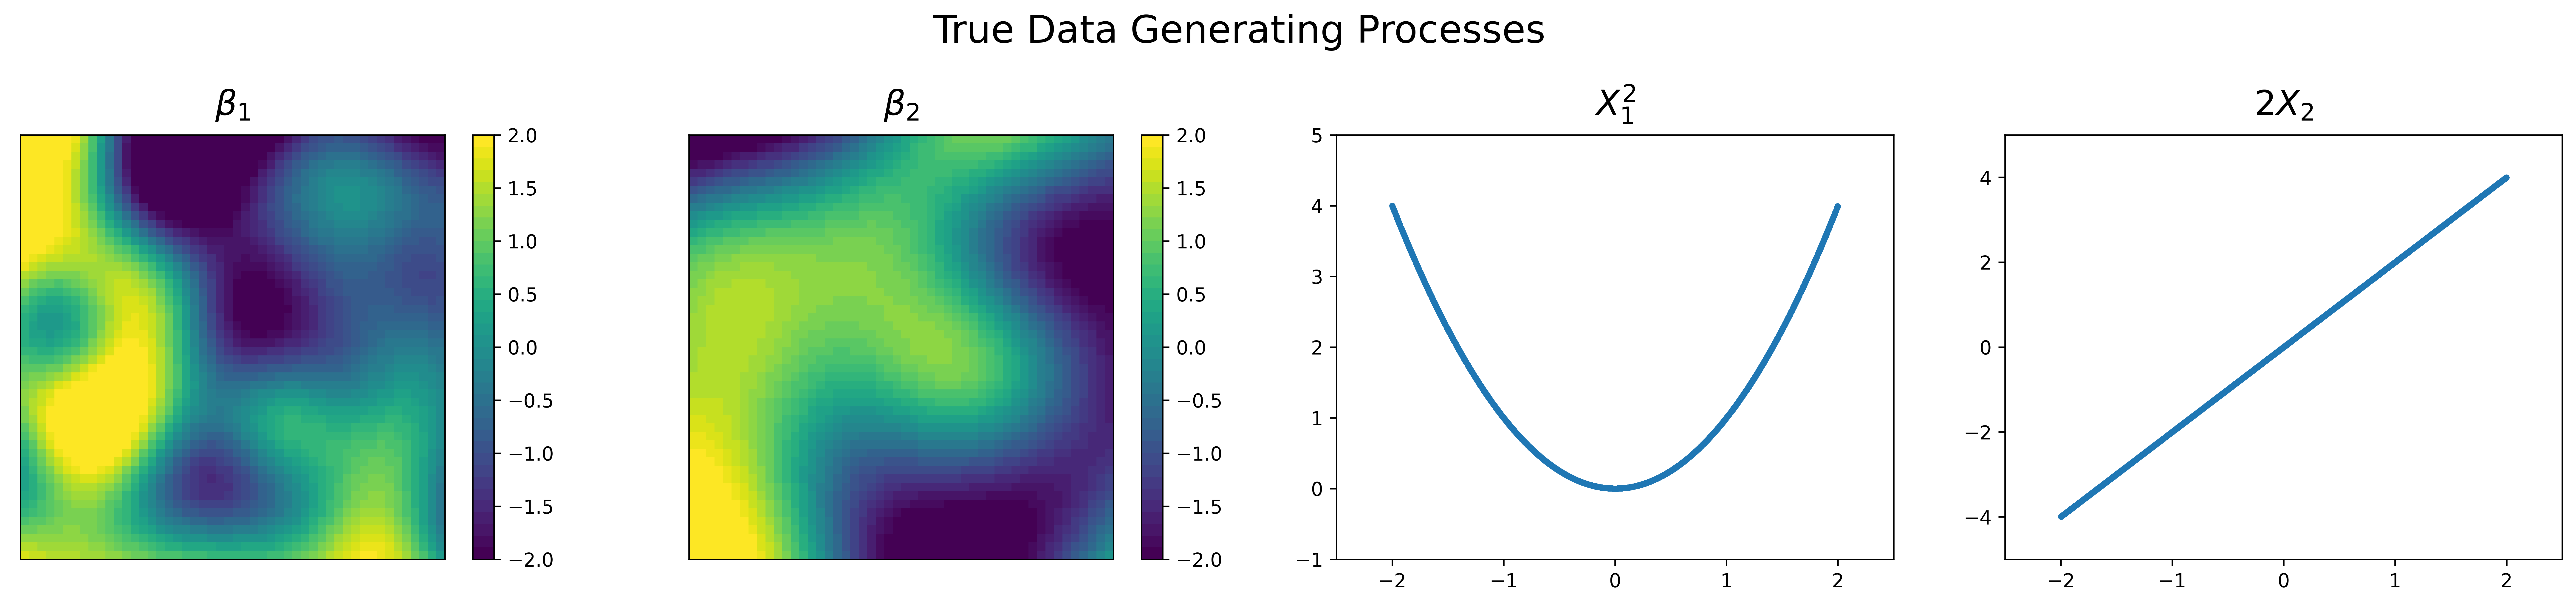

In [13]:
plot_s(np.vstack([b1, b2, X1**2,X2*2]),vmin=-2,vmax=2,title="True Data Generating Processes")
plt.savefig("grid_true_processes.png",bbox_inches="tight")

In [14]:
X_coords.loc[:,['u','v']] = coords#(np.array(coords) - np.array(coords).mean(axis=0))/np.array(coords).std(axis=0)

In [15]:
data = X_coords.copy()
data['y'] = y.reshape(-1)

In [16]:
data.to_csv("data/grid_coords.csv")

In [17]:
y

array([3.604881  , 2.21040345, 3.0753112 , ..., 3.58159443, 4.57441376,
       5.29378635])

In [18]:
import libpysal.weights
import numpy.linalg as LA
w = libpysal.weights.lat2W(size,size,rook =False)

In [19]:
def extract_sf(w, style='B'):
    w.transform = style
    C, ids = libpysal.weights.full(w)
    n = C.shape[0]
    M = np.identity(n) - (1/n)
    MCM = np.dot(np.dot(M,C),M)
    vals, vecs = LA.eigh(MCM)
    vals, vecs = np.array(vals), np.array(vecs.T)
    #Sort vals and vecs because they aren't in decending order in python
    pairs = zip(vals, vecs)
    svals = sorted(vals, reverse=True)
    stups = [None] * len(svals)
    for e_val, vector in pairs:
        stups[svals.index(e_val)] = (e_val, vector)
        svals[svals.index(e_val)] = None
    vecs = np.array([x[1] for x in stups])
    vals = np.array([x[0] for x in stups])
    return vals, vecs

vals, vecs = extract_sf(w, 'B')

In [20]:
data = vecs[range(0,200,1)]
moran = data.T

In [21]:
data_moran = pd.DataFrame(X, columns=['X1','X2'])

In [22]:
moran_names = ["moran_" + str(i) for i in range(moran.shape[1])]

data_moran.loc[:,moran_names] = moran

In [23]:
data_moran.loc[:,['u','v']] = coords

In [24]:
data_moran['y'] = y.reshape(-1)

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_60593/867605302.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_moran['y'] = y.reshape(-1)


In [25]:
data_moran.to_csv("data/grid_moran_queen.csv")

In [26]:
moran_exp = pd.read_csv("data/grid_moran_e_exp.csv")

In [27]:
data_moran.iloc[:,2:-3] = moran_exp.values

In [28]:
data_moran.to_csv("data/grid_moran_exp.csv")